In [1]:
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langgraph.checkpoint.memory import MemorySaver
# from langgraph.graph import END,StateGraph,MessageState
from langgraph.prebuilt import ToolNode

In [4]:
from langgraph.graph import END,StateGraph,MessagesState

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

agent = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest",convert_system_message_to_human=True)

In [6]:
from langchain_core.tools import tool


In [7]:
@tool
def search(query: str) -> str:
    """
    Finds the current weather for a given location.
    This tool only has information for San Francisco.
    """
    # Use query.lower() with parentheses to actually run the function
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 40 degrees in San Francisco."

    # Corrected the typo in the default response
    return "It's 76 degrees and sunny elsewhere."


In [8]:
tools=[search]

In [9]:
tool_node=ToolNode(tools)

In [10]:
def call_model(state:MessagesState):
    messages=state['messages']
    response= agent.invoke(messages)
    return {"messgaes":[response]}

In [11]:
from typing import Literal

In [12]:
  def should_continue(state:MessagesState) -> Literal["tools",END]:
    messages=state['messages']
    last_message=messages[-1]
    ## if llm make a tool call then we route to the tools node
    if last_message.tool_calls:
      return "tools"
    return END


In [13]:
workflow=StateGraph(MessagesState)

In [14]:
workflow.add_node("agent",call_model)

In [15]:
workflow.add_node("tools",call_model)

In [16]:
workflow.add_conditional_edges(
    #first is the start node we use agent then we use should_continue_edges
    "agent",
    should_continue
)

In [17]:
workflow.set_entry_point("agent")

In [18]:
workflow.add_edge("tools",'agent')

In [19]:
checkpointer=MemorySaver()

In [20]:
app=workflow.compile(checkpointer=checkpointer)

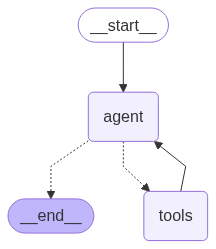

In [21]:
from IPython.display import Image,display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass    

In [22]:
from langchain_core.messages import HumanMessage

In [23]:
final_state=app.invoke(
    {"messages": [HumanMessage(content="Hello, how can I help you today?")] },
    config={"configurable":{"thread_id":42}}
)

c:\Users\gagan\anaconda3\envs\chain\lib\site-packages\langchain_google_genai\chat_models.py:499: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


AttributeError: 'HumanMessage' object has no attribute 'tool_calls'